In [6]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Path to the dataset folder
data_dir = "/media/usama/SSD/Data_for_SAM2_model_Finetuning/notebook/data/"
images_dir = os.path.join(data_dir, "image_tiles/")
masks_dir = os.path.join(data_dir, "mask_tiles/")

# List all image and mask files
image_files = sorted(os.listdir(images_dir))  # All image filenames
mask_files = sorted(os.listdir(masks_dir))    # All mask filenames

# Create a dictionary to map image filenames to corresponding mask filenames
image_mask_mapping = {}

# Assuming filenames have some common pattern (e.g., image_001.png, mask_001_1.png)
for image_file in image_files:
    # Extract image ID
    image_id = os.path.splitext(image_file)[0]
    corresponding_masks = [mask for mask in mask_files if image_id in mask]

    # Store the image and its corresponding masks
    image_mask_mapping[image_file] = corresponding_masks

# Create the list of all image-mask pairs
all_pairs = []
for image_file, mask_list in image_mask_mapping.items():
    for mask_file in mask_list:
        image_path = os.path.join(images_dir, mask_file)
        mask_path = os.path.join(masks_dir, mask_file)
        all_pairs.append({"image": image_path, "annotation": mask_path})

print(f"Training data size: {len(all_pairs)}")

# Split the data into train and test sets
train_pairs, test_pairs = train_test_split(all_pairs, test_size=0.0, random_state=42)
# print("train_pairs",len(train_pairs))

# Save training data to 'train_data.txt'
with open("train_data.txt", "a") as train_file:
    for pair in train_pairs:
        # print("pair",pair)
        train_file.write(f"'image_path':{pair['image']},'annotation_path': {pair['annotation']}\n")

# Save testing data to 'test_data.txt'
with open("test_data.txt", "a") as test_file:
    for pair in test_pairs:
        test_file.write(f"'image_path':{pair['image']}, 'annotation_path':{pair['annotation']}\n")

# Optionally, print the sizes and some examples for verification
print(f"Training data size: {len(train_pairs)}")
# print(f"Testing data size: {len(test_pairs)}")
print("Sample training data:", train_pairs[:2])
# print("Sample testing data:", test_pairs[:5])

Training data size: 2
all pairs [{'image': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/notebook/data/image_tiles/19_4326_41.jpg', 'annotation': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/notebook/data/mask_tiles/19_4326_41.jpg'}, {'image': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/notebook/data/image_tiles/4_4326_50.jpg', 'annotation': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/notebook/data/mask_tiles/4_4326_50.jpg'}]


In [9]:
from shapely.geometry import Polygon
import cv2
from shapely.validation import make_valid
import numpy as np
import random
import matplotlib.pyplot as plt

In [39]:
def get_representative_points_within_contours(contours, contours_1):
    """Get representative points within each part of the polygon or a reduced number if there's intersection with contours_1."""
    representative_points = []

    def get_quadrant_representative_points(polygon):
        """Get representative points from the quadrants of a polygon."""
        min_x, min_y, max_x, max_y = polygon.bounds
        center_x = (min_x + max_x) / 2
        center_y = (min_y + max_y) / 2

        quadrants = [
            Polygon([(min_x, min_y), (center_x, min_y), (center_x, center_y), (min_x, center_y)]),
            Polygon([(center_x, min_y), (max_x, min_y), (max_x, center_y), (center_x, center_y)]),
            Polygon([(min_x, center_y), (center_x, center_y), (center_x, max_y), (min_x, max_y)]),
            Polygon([(center_x, center_y), (max_x, center_y), (max_x, max_y), (center_x, max_y)])
        ]

        temp_points = []  # Temporary list to hold quadrant representative points

        for quadrant in quadrants:
            if quadrant.intersects(polygon):
                intersection = quadrant.intersection(polygon)
                if not intersection.is_empty:
                    rep_point = intersection.representative_point()
                    temp_points.append((rep_point.x, rep_point.y))

        return temp_points

    for contour_1 in contours_1:
        try:
            shapely_polygon = Polygon([(point[0][0], point[0][1]) for point in contour_1])
            shapely_polygon = make_valid(shapely_polygon)  # Ensure the polygon is valid
            count = 0
            tmp_pts = []

            for contour in contours:
                # shapely_polygon_1 = Polygon([(point[0][0], point[0][1]) for point in contour])
                coordinates = []
                for point in contour:
                    x = point[0][0]
                    y = point[0][1]
                    coordinates.append((x, y))

                if len(coordinates)>3:
                # Create the polygon using the list of coordinates
                    shapely_polygon_1 = Polygon(coordinates)
                    shapely_polygon_1 = make_valid(shapely_polygon_1)  # Ensure the polygon is valid

                    if shapely_polygon.intersects(shapely_polygon_1):
                        count += 1

                        if shapely_polygon_1.area <= 200:
                            rep_point = shapely_polygon_1.representative_point()
                            representative_points.append((rep_point.x, rep_point.y))
                        else:
                           tmp_pts.append(get_quadrant_representative_points(shapely_polygon_1))

            if count > 1:
                if len(tmp_pts) >= 2:
                    representative_points.extend(random.sample(tmp_pts[0], 2))
                    representative_points.extend(random.sample(tmp_pts[1], 2))
                else:
                    representative_points.extend(tmp_pts[0])
            else:
                if tmp_pts:
                # If no multiple intersections, still get quadrant points
                    representative_points.extend(tmp_pts[0])


        except ValueError as e:
            print(f"Error creating polygon: {e}")
            continue

    return representative_points

Contours length before erosion: 4
Contours length after erosion: 6


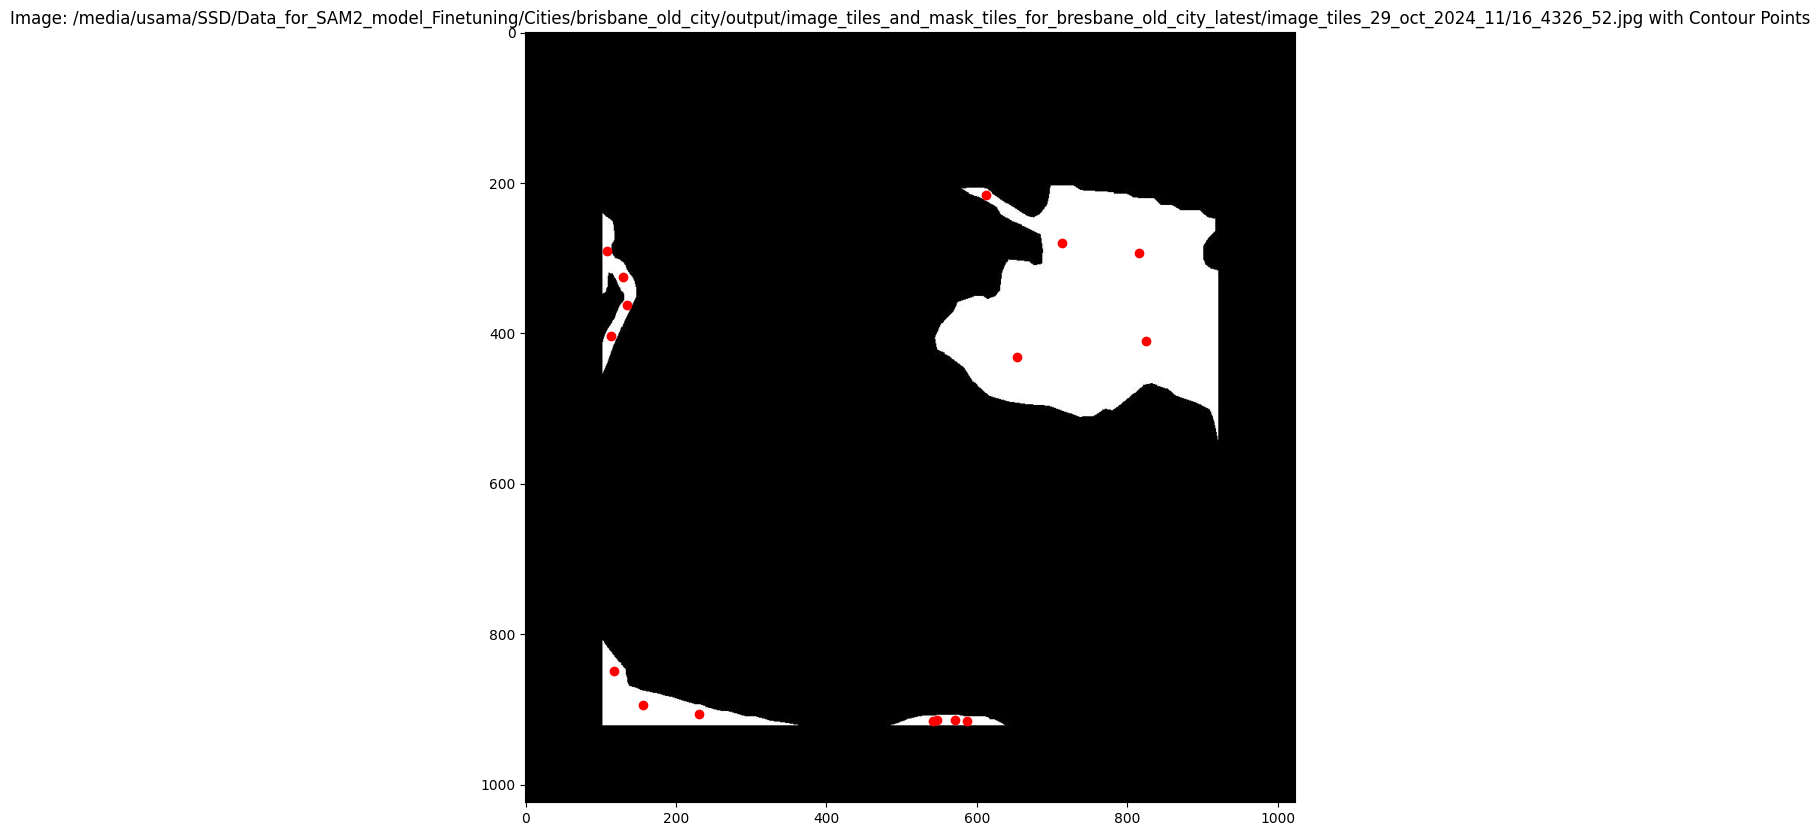

Length of results: 1


In [44]:
def read_batch(data, visualize_data=False):
    results = []

    for ent in data:
        image = cv2.imread(ent["image"])[..., ::-1]
        ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)

        if image is None or ann_map is None:
            print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
            continue

        scale = min(1024 / image.shape[1], 1024 / image.shape[0])
        image = cv2.resize(image, (int(image.shape[1] * scale), int(image.shape[0] * scale)))
        ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * scale), int(ann_map.shape[0] * scale)), interpolation=cv2.INTER_NEAREST)

        _, binary_mask = cv2.threshold(ann_map, 127, 255, cv2.THRESH_BINARY)
        contours_1, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        print("Contours length before erosion:", len(contours_1))

        eroded_mask = cv2.erode(ann_map, np.ones((5, 5), np.uint8), iterations=2)
        _, binary_mask_eroded = cv2.threshold(eroded_mask, 127, 255, cv2.THRESH_BINARY)
        contours_2, _ = cv2.findContours(binary_mask_eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        print("Contours length after erosion:", len(contours_2))

        final_mask = cv2.erode(ann_map, np.ones((5, 5), np.uint8), iterations=2) if len(contours_2) >= len(contours_1) else ann_map
        for i in range(1, 2):
            txt_file_path = 'contour_points.txt'
            _, binary_mask_final = cv2.threshold(final_mask, 100, 255, cv2.THRESH_BINARY)
            contours, _ = cv2.findContours(binary_mask_final, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Get representative points with intersection logic
            points = get_representative_points_within_contours(contours, contours_1)

            # Write points to text file
            with open(txt_file_path, 'a') as file:
                for (cX, cY) in points:
                    file.write(f'{cX}, {cY}\n')

            results.append({
                "image": ent["image"],
                "annotation": ent["annotation"],
                "txt_file": txt_file_path,
                "points": points
            })

            if visualize_data:
                plt.figure(figsize=(10, 10))
                plt.imshow(ann_map, cmap='gray')
                for (cX, cY) in points:
                    plt.plot(cX, cY, 'ro')
                plt.title(f"Image: {ent['image']} with Contour Points")
                plt.show()

    return results

# train_data = [{'image': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/notebook/data/image_tiles/19_4326_41.jpg', 'annotation': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/notebook/data/mask_tiles/19_4326_41.jpg'}]
# train_data =   [{'image': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/notebook/data/image_tiles/4_4326_50.jpg', 'annotation': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/notebook/data/mask_tiles/4_4326_50.jpg'}]
# train_data =   [{'image': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/brisbane_old_city/output/image_tiles_and_mask_tiles_for_bresbane_old_city_latest/image_tiles_29_oct_2024_11/19_4326_51.jpg', 'annotation': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/brisbane_old_city/output/image_tiles_and_mask_tiles_for_bresbane_old_city_latest/mask_tiles_29_oct_2024_11/19_4326_51.jpg'}]
train_data =   [{'image': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/brisbane_old_city/output/image_tiles_and_mask_tiles_for_bresbane_old_city_latest/image_tiles_29_oct_2024_11/16_4326_52.jpg', 'annotation': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/brisbane_old_city/output/image_tiles_and_mask_tiles_for_bresbane_old_city_latest/mask_tiles_29_oct_2024_11/16_4326_52.jpg'}]
results = read_batch(train_data, visualize_data=True)
print("Length of results:", len(results))

In [ ]:
# def get_representative_points_within_contours(contours, contours_1):
#     """Get representative points within each part of the polygon or a reduced number if there's intersection with contours_1."""
#     representative_points = []

#     def get_quadrant_representative_points(polygon):
#         """Get representative points from the quadrants of a polygon."""
#         min_x, min_y, max_x, max_y = polygon.bounds
#         center_x = (min_x + max_x) / 2
#         center_y = (min_y + max_y) / 2

#         quadrants = [
#             Polygon([(min_x, min_y), (center_x, min_y), (center_x, center_y), (min_x, center_y)]),
#             Polygon([(center_x, min_y), (max_x, min_y), (max_x, center_y), (center_x, center_y)]),
#             Polygon([(min_x, center_y), (center_x, center_y), (center_x, max_y), (min_x, max_y)]),
#             Polygon([(center_x, center_y), (max_x, center_y), (max_x, max_y), (center_x, max_y)])
#         ]

#         temp_points = []  # Temporary list to hold quadrant representative points

#         for quadrant in quadrants:
#             if quadrant.intersects(polygon):
#                 intersection = quadrant.intersection(polygon)
#                 if not intersection.is_empty:
#                     rep_point = intersection.representative_point()
#                     temp_points.append((rep_point.x, rep_point.y))

#         return temp_points

#     for contour_1 in contours_1:
#         try:
#             shapely_polygon = Polygon([(point[0][0], point[0][1]) for point in contour_1])
#             shapely_polygon = make_valid(shapely_polygon)  # Ensure the polygon is valid
#             count = 0
#             tmp_pts = []

#             for contour in contours:
#                 shapely_polygon_1 = Polygon([(point[0][0], point[0][1]) for point in contour])
#                 shapely_polygon_1 = make_valid(shapely_polygon_1)  # Ensure the polygon is valid

#                 if shapely_polygon.intersects(shapely_polygon_1):
#                     count += 1

#                 if shapely_polygon_1.area <= 200:
#                     rep_point = shapely_polygon_1.representative_point()
#                     representative_points.append((rep_point.x, rep_point.y))
#                 else:
#                   tmp_pts.append(get_quadrant_representative_points(shapely_polygon_1))

#             if count > 1:
#                 if len(tmp_pts) > 2:
#                     representative_points.extend(random.sample(tmp_pts[0], 2))
#                     representative_points.extend(random.sample(tmp_pts[1], 2))
#                 else:
#                     representative_points.extend(tmp_pts[0])
#             else:
#                 if tmp_pts:
#                 # If no multiple intersections, still get quadrant points
#                     representative_points.extend(tmp_pts[0])


#         except ValueError as e:
#             print(f"Error creating polygon: {e}")
#             continue

#     return representative_points